In [2]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import pydicom

In [3]:
# Training and testing data
train_input_data = ['Noisy Images/1-1_speckle_noise.png', 'Noisy Images/1-2_speckle_noise.png']
test_input_data = ['Noisy Images/1-6_speckle_noise.png']
train_output_data = ['Photos/1-1.dcm', 'Photos/1-2.dcm']
test_output_data = ['Photos/1-6.dcm']

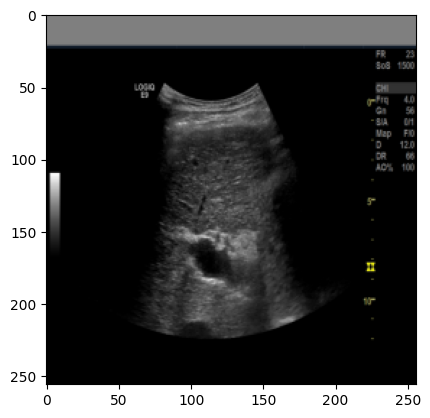

In [16]:
from skimage.transform import resize

dicom_file = pydicom.dcmread('Photos/1-1.dcm')
image_array = dicom_file.pixel_array

normalized_pixel_array = image_array / np.max(image_array)

new_size = (256, 256)
resized_image = resize(normalized_pixel_array, new_size, anti_aliasing=True)

plt.imshow(resized_image, cmap='gray')

In [18]:
# convert image to tensor
image_tensor = torch.tensor(resized_image)
image_tensor = image_tensor.unsqueeze(0)

In [26]:
print(image_tensor.shape)

torch.Size([1, 256, 256, 3])


In [34]:
# Create a model
import torch.nn as nn
import torch.nn.functional as F

class DenoisingModel(nn.Module):
    def __init__(self):
        super(DenoisingModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        
        return x
    
model = DenoisingModel()

In [35]:
# Train the model
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert image_tensor to float32
image_tensor = image_tensor.float()

for epoch in range(1000):
    optimizer.zero_grad()
    output = model(image_tensor)
    loss = criterion(output, image_tensor)
    loss.backward()
    optimizer.step()
    print('Epoch:', epoch, 'Loss:', loss.item())

Epoch: 0 Loss: 0.0348137691617012
Epoch: 1 Loss: 0.025464540347456932
Epoch: 2 Loss: 0.018721064552664757
Epoch: 3 Loss: 0.016482913866639137
Epoch: 4 Loss: 0.01546119898557663
Epoch: 5 Loss: 0.013181362301111221
Epoch: 6 Loss: 0.010506651364266872
Epoch: 7 Loss: 0.008995995856821537
Epoch: 8 Loss: 0.008948365226387978
Epoch: 9 Loss: 0.009242512285709381
Epoch: 10 Loss: 0.009118947200477123
Epoch: 11 Loss: 0.008774589747190475
Epoch: 12 Loss: 0.008554966188967228
Epoch: 13 Loss: 0.008472713641822338
Epoch: 14 Loss: 0.008386566303670406
Epoch: 15 Loss: 0.00821229163557291
Epoch: 16 Loss: 0.00792208593338728
Epoch: 17 Loss: 0.007561527658253908
Epoch: 18 Loss: 0.007193505764007568
Epoch: 19 Loss: 0.006831576582044363
Epoch: 20 Loss: 0.0065252953208982944
Epoch: 21 Loss: 0.006347566843032837
Epoch: 22 Loss: 0.0062666465528309345
Epoch: 23 Loss: 0.00619535194709897
Epoch: 24 Loss: 0.006107976194471121
Epoch: 25 Loss: 0.006034079473465681
Epoch: 26 Loss: 0.005993105936795473
Epoch: 27 Loss: